### Import Required Library:

In [2]:
# uncomment below line if below packages are not installed
!pip install -q segmentation-models-pytorch albumentations


In [2]:
import os, cv2, glob
import numpy as np
import pandas as pd
import random, tqdm
# import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
import torchmetrics
from tqdm import tqdm
import torch.nn.functional as F
from segmentation_models_pytorch.losses import DiceLoss
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

In [3]:
# Define path variables
BASE_DIR = '/home/opencvuniv/Work/somusan/blogpost/road_seg/data/'
TRAIN_DATA_PATH = os.path.join(BASE_DIR, 'csv/train.csv')
VAL_DATA_PATH = os.path.join(BASE_DIR, 'csv/val.csv')
DATA_DIR = os.path.join(BASE_DIR, 'data')

# Select the device to train on
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 25        # number of epochs
LR = 0.001         # Learning rate
IMG_SIZE = 320     # Size of image
BATCH_SIZE = 32    # Batch size 

# Define pretrained encoder model and weights
ENCODER = 'resnet50'
WEIGHTS = 'imagenet'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def get_data_path(csv_path):
    new_path = csv_path.replace("/home/somusan/OpencvUni/opencvblog/robotics-series/yolop_idd/", 
                                "data/")
    if os.path.exists(new_path):
        return new_path
    return -1

In [5]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
val_df = pd.read_csv(VAL_DATA_PATH)

print(train_df.shape)
train_df.head()
print(train_df['image'][0].replace("/home/somusan/OpencvUni/opencvblog/robotics-series/yolop_idd/", 
                                "data/"))
print(os.path.exists(train_df['mask'][0].replace("/home/somusan/OpencvUni/opencvblog/robotics-series/yolop_idd/", 
                                "data/")))


(6993, 2)
data/idd-segmentation/IDD_Segmentation/leftImg8bit/train/176/014452_leftImg8bit.png
True


In [7]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'road']
class_names = ['background', 'road']

class_rgb_values = [[0, 0, 0], [255, 255, 255]]
# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)



Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [8]:
def visualize(**images):
    """
    Plot images in one row.
    """
    n_images = len(images)
    plt.figure(figsize=(20, 8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()
    
    
    
# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x


def rgb_to_class(mask, class_rgb_values):
    """
    Map the RGB mask to a single-channel mask with class indices.
    """
    # Initialize the output mask with zeros
    mask_class = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
    for idx, color in enumerate(class_rgb_values):
        # Create a boolean mask where the pixels match the current class color
        matches = np.all(mask == color, axis=-1)
        # Assign the class index to the output mask
        mask_class[matches] = idx
    return mask_class


In [9]:
class RoadsDataset(torch.utils.data.Dataset):

    """Indian Driving Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (pandas.DataFrame): train or validation data frame
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.df = df
        self.image_paths = sorted([get_data_path(i) for i in self.df["image"].tolist()])
        self.mask_paths = sorted([get_data_path(i) for i in self.df["mask"].tolist()])

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        # mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB) 
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2GRAY) 
        

        mask = mask.astype('long') / 255.




        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

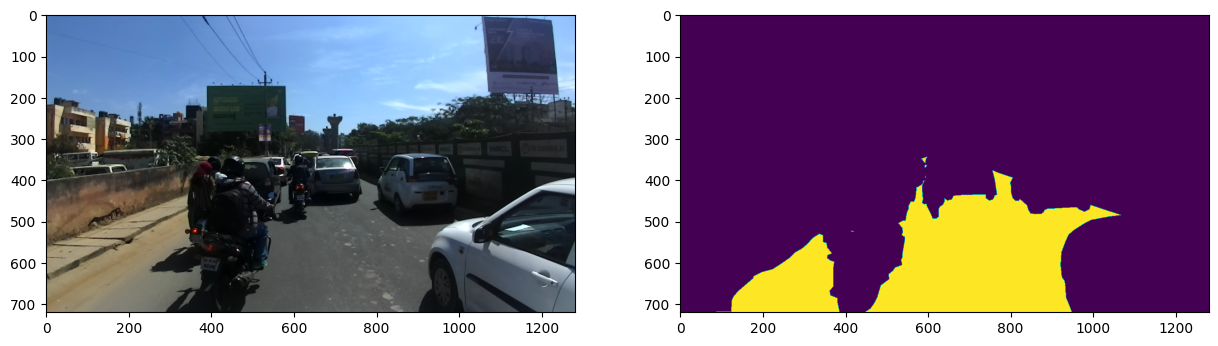

In [10]:
dataset = RoadsDataset(train_df, class_rgb_values=select_class_rgb_values)
image, mask = dataset[4524]


plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.imshow(image)

plt.subplot(1,2,2)
plt.imshow(mask)

plt.show()


In [11]:

def get_training_augmentation():
    train_transform = [
        album.Resize(
            height=480, width=640, always_apply=True,
            interpolation=cv2.INTER_LINEAR, 
        ),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                # Add other augmentations if needed
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():
    return album.Compose([
        album.Resize(
            height=480, width=640, always_apply=True,
            interpolation=cv2.INTER_LINEAR, 
        ),
    ])

# def to_tensor(x, **kwargs):
#     return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(
        album.Lambda(image=to_tensor, mask=to_tensor_mask)
    )
    return album.Compose(_transform)


def to_tensor(x, **kwargs):
    if x.ndim == 2:
        x = np.expand_dims(x, axis=0)  # Add a channel dimension for masks
    else:
        x = x.transpose(2, 0, 1)
    return x.astype('float32')


def to_tensor_mask(x, **kwargs):
    return x[np.newaxis, ...].astype('long')  # Convert to (1, H, W) and ensure type is long

def custom_collate_fn(batch):
    # Separate the images and masks
    images, masks = zip(*batch)
    
    # Do custom processing here (like padding to the largest image/mask in the batch)
    # Example: Use list comprehension to convert to tensors
    images = [torch.as_tensor(image) for image in images]
    masks = [torch.as_tensor(mask) for mask in masks]
    
    return images, masks  # Return list of images and masks

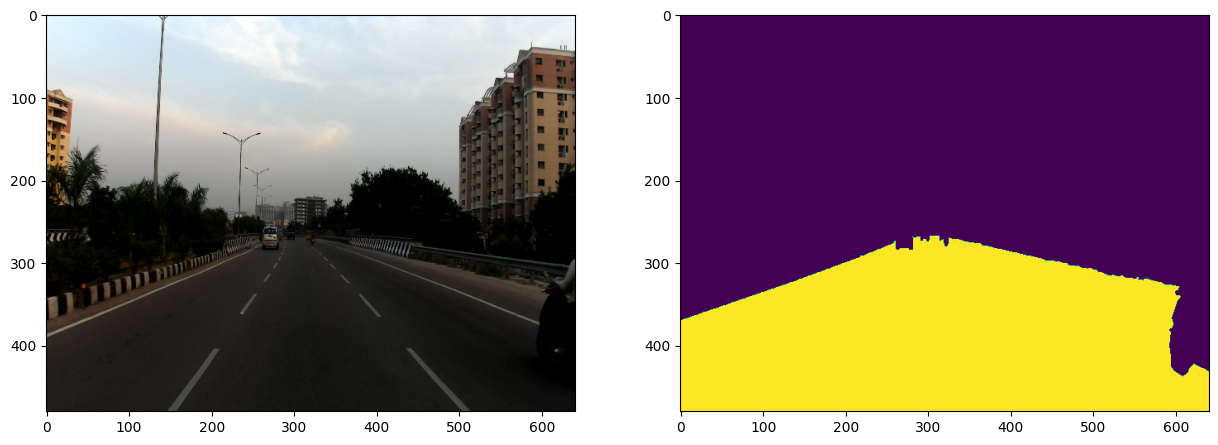

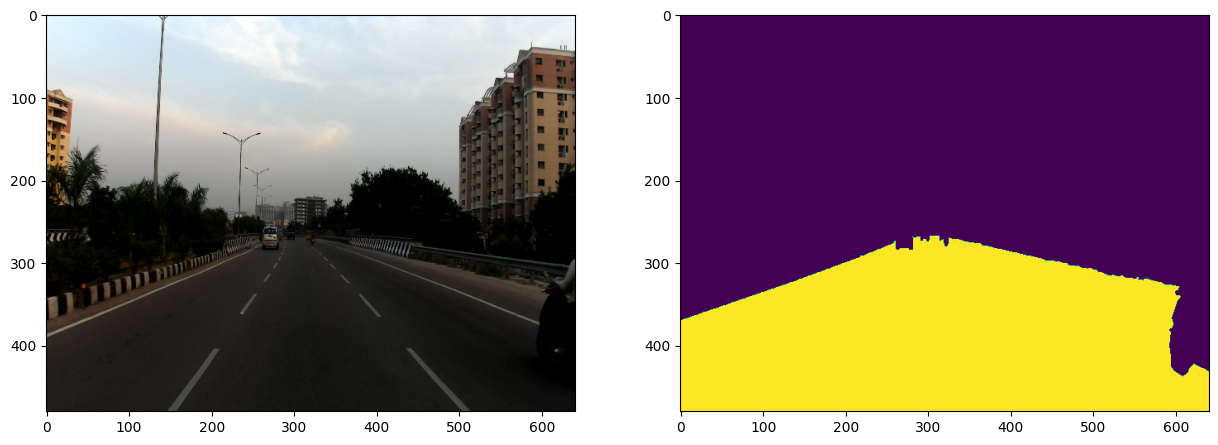

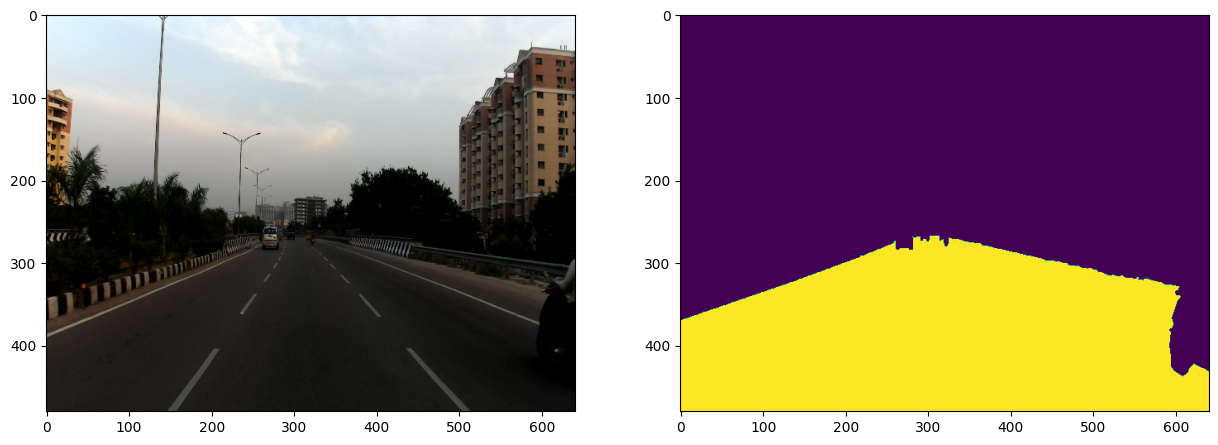

In [12]:
augmented_dataset = RoadsDataset(
    train_df,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
#     visualize(
#         original_image = image,
#         ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
#         one_hot_encoded_mask = reverse_one_hot(mask)
#     )

    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    plt.imshow(image)

    plt.subplot(1,2,2)
    plt.imshow(mask)

    plt.show()
    

In [13]:


class Conv2dReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(Conv2dReLU, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.conv1 = Conv2dReLU(in_channels, out_channels)
        self.conv2 = Conv2dReLU(out_channels, out_channels)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    
    def forward(self, x, skip):
        # Upsample
        x = self.up(x)
        
        # Resize skip connection to match the size of x
        if x.size() != skip.size():
            skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=True)
        
        # Concatenate the skip connection (encoder output)
        x = torch.cat([x, skip], dim=1)
        
        # Apply convolutions
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNetResNet50(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(UNetResNet50, self).__init__()

        # Load ResNet50 pre-trained on ImageNet
#         self.encoder = models.resnet50(pretrained=pretrained)
        self.encoder = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
        

        # Encoder layers from ResNet-50 (for skip connections)
        self.encoder_layers = [
            nn.Sequential(self.encoder.conv1, self.encoder.bn1, self.encoder.relu, self.encoder.maxpool),  # (64, H/4, W/4)
            self.encoder.layer1,  # (256, H/4, W/4)
            self.encoder.layer2,  # (512, H/8, W/8)
            self.encoder.layer3,  # (1024, H/16, W/16)
            self.encoder.layer4   # (2048, H/32, W/32)
        ]

        # Decoder (Upsampling blocks)
        self.decoder4 = DecoderBlock(2048 + 1024, 512)  # Block for layer4 + layer3
        self.decoder3 = DecoderBlock(512 + 512, 256)    # Block for layer3 + layer2
        self.decoder2 = DecoderBlock(256 + 256, 128)    # Block for layer2 + layer1
        self.decoder1 = DecoderBlock(128 + 64, 64)      # Block for layer1 + conv1

        # Final segmentation head
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(64, num_classes, kernel_size=3, padding=1),
            # nn.Sigmoid()  # Use sigmoid for binary segmentation
        )

    def forward(self, x):
        # Save original input size for final upsampling
        original_size = x.shape[2:]  # (H, W)

        # Encoder forward pass
        x0 = self.encoder_layers[0](x)  # Initial convolution block (conv1)
        x1 = self.encoder_layers[1](x0)  # Skip connection 1 (layer1)
        x2 = self.encoder_layers[2](x1)  # Skip connection 2 (layer2)
        x3 = self.encoder_layers[3](x2)  # Skip connection 3 (layer3)
        x4 = self.encoder_layers[4](x3)  # Skip connection 4 (layer4)

        # Decoder forward pass
        x = self.decoder4(x4, x3)  # Decoder for layer4 + skip3
        x = self.decoder3(x, x2)   # Decoder for layer3 + skip2
        x = self.decoder2(x, x1)   # Decoder for layer2 + skip1
        x = self.decoder1(x, x0)    # Decoder for layer1 + initial conv1 output

        # Upsample the final output to match the input size dynamically
        x = F.interpolate(x, size=original_size, mode='bilinear', align_corners=True)

        # Final segmentation output
        x = self.segmentation_head(x)

        return x

# # Example usage
# if __name__ == "__main__":
#     # Instantiate the model
#     model = UNetResNet50(num_classes=2, pretrained=True)
    
#     # Test the model with dummy input
#     input_tensor = torch.rand(1, 3, 480, 640)  # Batch size 1, 3 channels (RGB), 480x640 image
#     output = model(input_tensor)
    
#     print(f"Output shape: {output.shape}")  # Should output (1, 2, 480, 640) for binary segmentation

In [14]:
# Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" 
# to /home/opencvuniv/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth

ENCODER = 'resnet50'  # 'timm-efficientnet-b0' # 
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation


model = UNetResNet50(num_classes=2, pretrained=True)
model.to(DEVICE)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Using cache found in /home/opencvuniv/.cache/torch/hub/facebookresearch_dino_main


In [15]:
# Get train and val dataset instances
train_dataset = RoadsDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    val_df,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import kornia
import kornia.feature  # Import distance_transform from here

class BoundaryLoss(nn.Module):
    def __init__(self, idc=[1]):
        super(BoundaryLoss, self).__init__()
        self.idc = idc

    def forward(self, logits, targets):
        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=1)

        # Create one-hot encoded version of targets
        targets_onehot = F.one_hot(targets.squeeze(1), num_classes=logits.shape[1]).permute(0, 3, 1, 2).float()

        # Compute the distance maps
        gt_distance = self.compute_distance_map(targets_onehot)
        pred_probs = probs

        # Compute the boundary loss
        boundary_loss = (pred_probs * gt_distance).mean()

        return boundary_loss

    def compute_distance_map(self, one_hot):
        # Initialize distance map
        dist_map = torch.zeros_like(one_hot)
        for c in self.idc:
            fg = one_hot[:, c, :, :]
            if fg.sum() == 0:
                continue
            # Compute distance transform
            dist = kornia.contrib.distance_transform(fg.unsqueeze(1))
            dist_map[:, c, :, :] = dist[:, 0, :, :]
        return dist_map


In [17]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs


# Set device: `cuda` or `cpu`


# define loss function
dice_loss = DiceLoss(mode='multiclass')
cross_entropy_loss = nn.CrossEntropyLoss()
loss_fn = lambda outputs, targets: dice_loss(outputs, targets) + cross_entropy_loss(outputs, targets)
# loss_fn = dice_loss

# Define individual loss functions
# cross_entropy_loss = nn.CrossEntropyLoss()
# boundary_loss = BoundaryLoss(idc=[1])  # Assuming class '1' is the road class

# Define a combined loss function
# def combined_loss(outputs, targets):
#     ce_loss = cross_entropy_loss(outputs, targets.squeeze(1))
#     b_loss = boundary_loss(outputs, targets)
#     total_loss = ce_loss + 0.3 * b_loss
#     return total_loss
    

# define metrics
# iou_metric = torchmetrics.JaccardIndex(num_classes=2, task="binary").to(DEVICE)
iou_metric = torchmetrics.JaccardIndex(num_classes=2, task="multiclass").to(DEVICE)

# metrics = [
#     torchmetrics.JaccardIndex(num_classes=2, task="binary").to(DEVICE)
# ]

# define optimizer
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=1e-4,  weight_decay=1e-5)])


# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
# if os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
#     model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)

In [18]:

# Sample training loop
def train_one_epoch(model, dataloader, optimizer, loss_fn, iou_metric, device):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    
    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        # print(outputs.shape, masks.squeeze(1).shape)
        loss = loss_fn(outputs, masks.squeeze(1))
        # loss = combined_loss(outputs, masks.squeeze(1))
        
        # Zero gradients, backpropagation, and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss and IoU
        running_loss += loss.item()
#         running_iou += iou_metric(outputs, masks).item()
        # Compute IoU
        preds = torch.argmax(outputs, dim=1)
#         print(preds.shape, masks.squeeze(1).shape)
        running_iou += iou_metric(preds, masks.squeeze(1)).item()
    
    return running_loss / len(dataloader), running_iou / len(dataloader)



# Modified validation loop with visualization
def validate_one_epoch(model, dataloader, loss_fn, iou_metric, device, visualize=False, num_visualizations=2):
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    visualizations_done = 0

    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(dataloader)):
            images, masks = images.to(device), masks.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Compute loss
            loss = loss_fn(outputs, masks.squeeze(1))
            # loss = combined_loss(outputs, masks.squeeze(1))

            # Accumulate loss and IoU
            val_loss += loss.item()
#             val_iou += iou_metric(outputs, masks).item()
            # Compute IoU
            preds = torch.argmax(outputs, dim=1)
            val_iou += iou_metric(preds, masks.squeeze(1)).item()
            
            # Visualization logic
            if visualize and visualizations_done < num_visualizations:
                # Randomly pick a batch index
                # random_idx = random.randint(0, images.size(0) - 1)
                visualize_segmentation(images, 
                                        masks, 
                                        outputs)
                visualizations_done += 1

    return val_loss / len(dataloader), val_iou / len(dataloader)

def visualize_segmentation(images, masks, outputs):
    # Convert tensors to CPU and detach
    images = images.cpu().detach()
    masks = masks.cpu().detach()
    outputs = outputs.cpu().detach()

    # Get predicted class indices
    preds = torch.argmax(outputs, dim=1)

    # Loop through the batch and visualize
    for i in range(min(images.shape[0], 1)):
        fig, axs = plt.subplots(1, 3, figsize=(15, 10))

        # Plot the input image
        axs[0].imshow(images[i].permute(1, 2, 0))
        axs[0].set_title("Input Image")
        axs[0].axis('off')

        # Plot the ground truth mask
        axs[1].imshow(masks[i].reshape(480, 640), cmap='gray')
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis('off')

        # Plot the predicted mask
        axs[2].imshow(preds[i], cmap='gray')
        axs[2].set_title("Predicted Mask")
        axs[2].axis('off')

        plt.show()



train_loss_list = []
val_loss_list = []

train_iou_list = []
val_iou_list = []

# Example usage
for epoch in range(1, EPOCHS+1):
    train_loss, train_iou = train_one_epoch(model, train_loader, optimizer, loss_fn, iou_metric, DEVICE)
    val_loss, val_iou = validate_one_epoch(model, valid_loader, loss_fn, iou_metric, DEVICE, visualize=True)

    # Loss storing
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    # IOU storing
    train_iou_list.append(train_iou)
    val_iou_list.append(val_iou)
    
    
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Train IoU = {train_iou:.4f}")
    print(f"          Val Loss = {val_loss:.4f}, Val IoU = {val_iou:.4f}")
    
    
    if os.path.exists("models/base_line_e50_v3/"):
        torch.save(model.state_dict(), f'models/base_line_e50_v3/model_epoch_{epoch}.pth')  # Save the model weights
    else:
        os.makedirs("models/base_line_e50_v3/")
        torch.save(model.state_dict(), f'models/base_line_e50_v3/model_epoch_{epoch}.pth')  # Save the model weights

 89%|████████▉ | 781/875 [03:16<00:23,  3.99it/s]

In [ ]:
# !mkdir -p /kaggle/working/models/base_line_e50_v1/

In [ ]:

train_loss_list = []
val_loss_list = []

train_iou_list = []
val_iou_list = []

# Example usage
for epoch in range(1, EPOCHS+1):
    train_loss, train_iou = train_one_epoch(model, train_loader, optimizer, loss_fn, iou_metric, DEVICE)
    val_loss, val_iou = validate_one_epoch(model, valid_loader, loss_fn, iou_metric, DEVICE, visualize=True)

    # Loss storing
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    # IOU storing
    train_iou_list.append(train_iou)
    val_iou_list.append(val_iou)
    
    
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Train IoU = {train_iou:.4f}")
    print(f"          Val Loss = {val_loss:.4f}, Val IoU = {val_iou:.4f}")
    
